<a href="https://colab.research.google.com/github/johanjun/dacon_growthperiod/blob/main/training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
## library import
import tensorflow as tf
from tensorflow import keras
import numpy as np
import os
import re
from PIL import Image
import shutil
from sklearn.model_selection import train_test_split
import random
import matplotlib.pyplot as plt
from glob import glob
import pandas as pd
from tqdm import tqdm

pd.options.display.max_rows = 1000
pd.options.display.max_columns = 1000

In [3]:
root_dir = '/content/drive/MyDrive/dacon_growthperiod/open'
train_data_dir = os.path.join(root_dir, 'train_dataset')
test_data_dir = os.path.join(root_dir, 'test_dataset')

In [4]:
# The following functions can be used to convert a value to a type compatible
# with tf.Example.

def _bytes_feature(value):
  """Returns a bytes_list from a string / byte."""
  if isinstance(value, type(tf.constant(0))):
    value = value.numpy() # BytesList won't unpack a string from an EagerTensor.
  return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def _float_feature(value):
  """Returns a float_list from a float / double."""
  return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))

def _int64_feature(value):
  """Returns an int64_list from a bool / enum / int / uint."""
  return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

In [6]:
train_dir = os.path.join(train_data_dir, 'train')
val_dir = os.path.join(train_data_dir, 'validation')

tfr_dir = os.path.join(train_data_dir, 'tfrecord')

tfr_train_dir = os.path.join(tfr_dir, 'cls_train.tfr')
tfr_val_dir = os.path.join(tfr_dir, 'cls_val.tfr')

In [7]:
n_train = 11690
n_val = 2923

In [9]:
N_EPOCHS = 15
N_BATCH = 40
N_TRAIN = n_train
N_VAL = n_val
IMG_SIZE = 224
learning_rate = 0.0001
steps_per_epoch = N_TRAIN / N_BATCH
validation_steps = int(np.ceil(N_VAL / N_BATCH))

In [117]:
## tfrecord file을 data로 parsing해주는 function
def _parse_function(tfrecord_serialized):
    features={'before_image': tf.io.FixedLenFeature([], tf.string),
              'after_image': tf.io.FixedLenFeature([], tf.string),
              'time_delta': tf.io.FixedLenFeature([], tf.int64),
              'species': tf.io.FixedLenFeature([], tf.int64)              
             }
    parsed_features = tf.io.parse_single_example(tfrecord_serialized, features)
    
    bimage = tf.io.decode_raw(parsed_features['before_image'], tf.uint8)    
    bimage = tf.reshape(bimage, [IMG_SIZE, IMG_SIZE, 3])
    bimage = tf.cast(bimage, tf.float32)/255.

    aimage = tf.io.decode_raw(parsed_features['after_image'], tf.uint8)    
    aimage = tf.reshape(aimage, [IMG_SIZE, IMG_SIZE, 3])
    aimage = tf.cast(aimage, tf.float32)/255. 

    time_delta = tf.cast(parsed_features['time_delta'], tf.int64)
    species = tf.cast(parsed_features['species'], tf.int64)

    return bimage, aimage, species, time_delta

In [105]:
## train dataset 만들기
train_dataset = tf.data.TFRecordDataset(tfr_train_dir)
train_dataset = train_dataset.map(_parse_function, num_parallel_calls=tf.data.experimental.AUTOTUNE)
train_dataset = train_dataset.shuffle(N_TRAIN).prefetch(
    tf.data.experimental.AUTOTUNE).batch(N_BATCH).repeat()

In [106]:
## validation dataset 만들기
val_dataset = tf.data.TFRecordDataset(tfr_val_dir)
val_dataset = val_dataset.map(_parse_function, num_parallel_calls=tf.data.experimental.AUTOTUNE)
val_dataset = val_dataset.batch(N_BATCH)

tf.Tensor(8, shape=(), dtype=int64) tf.Tensor(0, shape=(), dtype=int64)


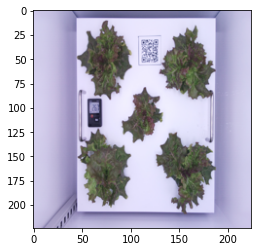

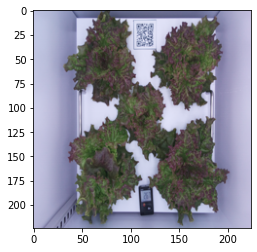

In [97]:
for bimage, aimage, time_delta in train_dataset.take(1):
  print(time_delta[0], species[0])
  plt.imshow(bimage[0])
  plt.show()
  plt.imshow(aimage[0])
  plt.show()

tf.Tensor(29, shape=(), dtype=int64) tf.Tensor(1, shape=(), dtype=int64)


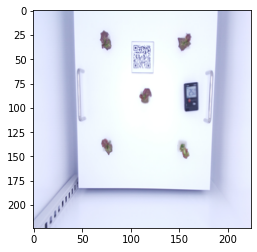

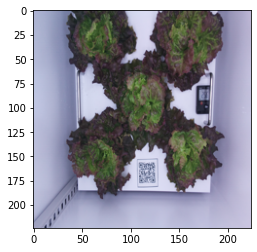

In [98]:
for bimage, aimage, time_delta in val_dataset.take(1):
  print(time_delta[1], species[1])
  # print(bimage)
  # print(aimage)
  plt.imshow(bimage[1])
  plt.show()
  plt.imshow(aimage[1])
  plt.show()

In [107]:
from tensorflow.keras import models
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.layers import Conv2D, ReLU, MaxPooling2D, Dense, BatchNormalization, GlobalAveragePooling2D

In [116]:
mobilenetv2 = MobileNetV2(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))

In [113]:
def create_mv_model():
  model = models.Sequential()
  model.add(mobilenetv2)
  model.add(GlobalAveragePooling2D())  
  model.add(Dense(1, activation='relu'))
  return model

In [114]:
## Create model, compile & summary
model = create_mv_model()

## learning rate scheduing
lr_schedule = keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=learning_rate,
                                                          decay_steps=steps_per_epoch*5,
                                                          decay_rate=0.5,
                                                          staircase=True)
model.compile(optimizer=tf.keras.optimizers.Adam(lr_schedule),
              loss='mean_squared_error',
              metrics=['accuracy'])

In [115]:
history = model.fit(
    train_dataset,
    epochs=N_EPOCHS,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_dataset,
    validation_steps=validation_steps
)

Epoch 1/15


ValueError: ignored